In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns  # >= 0.9

import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set(style='ticks', context='poster', color_codes=True, rc={
    'figure.figsize': [10, 6],
    'legend.fontsize': 18,
    'lines.linewidth' : 5,
    'patch.linewidth': 2.2,
    'hatch.linewidth': 2,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.minor.visible': True,
    'ytick.minor.visible': True,
    'xtick.minor.size': 5,
    'ytick.minor.size': 5,
})

In [3]:
from dataloader import *
sn_data = import_kaepora()
sn_data = sn_data[~sn_data['z'].isna()]
sn_data.head()

,v_siII,v_siII_err,z
kaepora,,,
2006td,10812.60,300.000,0.015880
1996z,12142.10,233.568,0.007575
1996x,11173.10,222.453,0.006945
1996c,10689.10,222.453,0.027000
2005m,8093.94,231.052,0.022000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


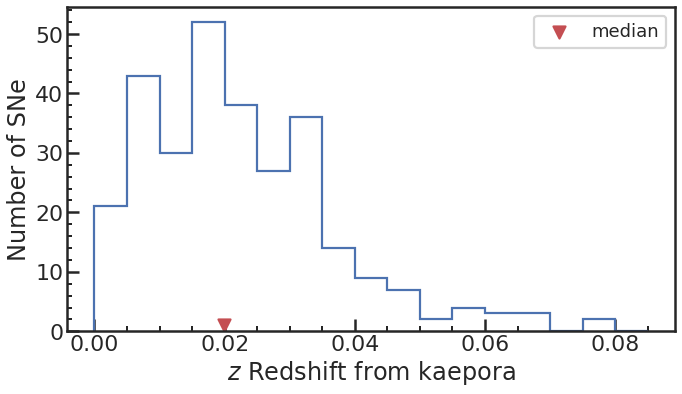

In [4]:
z_median = sn_data['z'].median()

bins = np.arange(0, 9, 0.5) / 100
plt.hist(sn_data['z'], bins=bins, histtype='step')
plt.scatter(z_median, 1, color='r', marker='v', label="median")

plt.xlabel('$z$ Redshift from kaepora')
plt.ylabel('Number of SNe')
plt.legend()

plt.tight_layout()
plt.savefig('results/z_histogram.eps', orientation='landscape', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


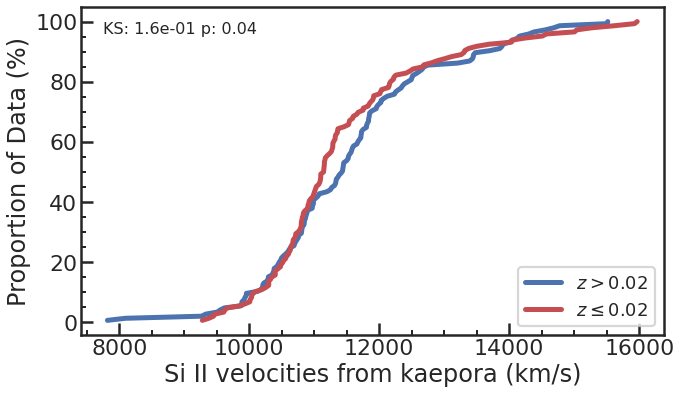

In [9]:
from scipy import stats

cutoff = z_median
ks = stats.ks_2samp(sn_data['v_siII'][sn_data['z'] > cutoff], sn_data['v_siII'][sn_data['z'] <= cutoff])

bins = np.arange(7000, 17000, 500)

x = sn_data['v_siII'][sn_data['z'] > cutoff]
plt.plot(np.sort(x), np.arange(1, len(x) + 1) / len(x) * 100, label=f'$z > {cutoff:.2g}$')

x = sn_data['v_siII'][sn_data['z'] <= cutoff]
plt.plot(np.sort(x), np.arange(1, len(x) + 1) / len(x) * 100, color='r', label=f'$z \leq {cutoff:.2g}$')

plt.xlabel('Si II velocities from kaepora (km/s)')
plt.ylabel("Proportion of Data (%)")
plt.title(f'KS: {ks[0]:.1e} p: {ks[1]:.2f}', x=0.17, y=0.9, fontsize=16)
plt.legend(loc='lower right')

plt.tight_layout()
plt.savefig('results/z_02_ks_test.eps', orientation='landscape', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


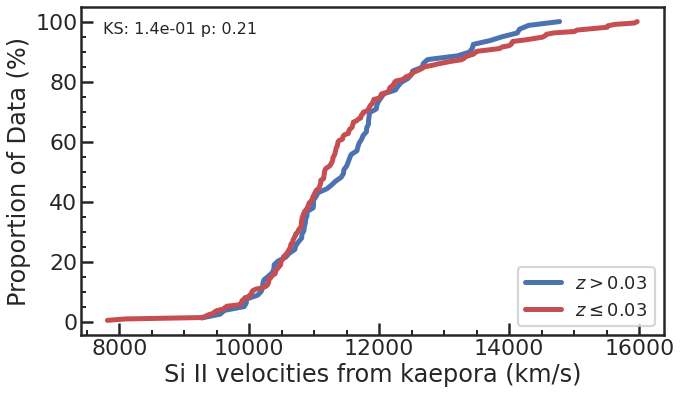

In [10]:
from scipy import stats

cutoff = 0.03
ks = stats.ks_2samp(sn_data['v_siII'][sn_data['z'] > cutoff], sn_data['v_siII'][sn_data['z'] <= cutoff])

bins = np.arange(7000, 17000, 500)

x = sn_data['v_siII'][sn_data['z'] > cutoff]
plt.plot(np.sort(x), np.arange(1, len(x) + 1) / len(x) * 100, label=f'$z > {cutoff:.2g}$')

x = sn_data['v_siII'][sn_data['z'] <= cutoff]
plt.plot(np.sort(x), np.arange(1, len(x) + 1) / len(x) * 100, color='r', label=f'$z \leq {cutoff:.2g}$')

plt.xlabel('Si II velocities from kaepora (km/s)')
plt.ylabel("Proportion of Data (%)")
plt.title(f'KS: {ks[0]:.1e} p: {ks[1]:.2f}', x=0.17, y=0.9, fontsize=16)
plt.legend(loc='lower right')

plt.tight_layout()
plt.savefig('results/z_03_ks_test.eps', orientation='landscape', format='eps')

In [18]:
sn_data['z'].sort_values()

kaepora
2014j     0.000677
2011fe    0.000804
2012cg    0.001460
1986g     0.001825
1994d     0.002058
            ...   
2006cj    0.067517
2006al    0.067849
2008y     0.069689
2003hu    0.075000
2005ag    0.079665
Name: z, Length: 291, dtype: float64

In [7]:
# plt.scatter(
#     np.histogram(sn_data_with_z['v_siII'][sn_data_with_z['z'] > z_median], bins)[0],
#     np.histogram(sn_data_with_z['v_siII'][sn_data_with_z['z'] <= z_median], bins)[0],
#     c=bins[:-1],
#     cmap='viridis'
# )
# plt.colorbar()

# plt.plot([0, 35], [0, 35], color='k', linewidth=4)

In [8]:
# plt.step(
#     bins[:-1],
#     np.histogram(sn_data_with_z['v_siII'][sn_data_with_z['z'] > z_median], bins)[0] - \
#     np.histogram(sn_data_with_z['v_siII'][sn_data_with_z['z'] <= z_median], bins)[0]
# )
# plt.xlabel('Si II Velocity (km/s)')
# plt.ylabel('Difference in Proportion of Data (%) \n $(> z_{50}) - (\leq z_{50})$')
